# Explicabilidad

In [1]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
except:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    os.environ["CUDA_VISIBLE_DEVICES"]="1" 
    print("No estoy en Google CoLab")
    COLAB = False

No estoy en Google CoLab


In [2]:
import tensorflow as tf
import matplotlib
import urllib
import numpy as np
import random
import urllib
import os
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_images(*args, tags=None):
    n = len(args[0])
    plt.figure(figsize=(20, 4*len(args)))
    for i in range(n):
        for j in range(len(args)):
            data = args[j][i]
            img = data['image']
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            cmap = None if 'cmap' not in data else data['cmap']
            
            if len(img.shape) == 3 and img.shape[2] == 1:
                ax.imshow(img.reshape(img.shape[:2]), cmap=cmap)
            else:
                ax.imshow(img, cmap=cmap)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            if 'tag' in data:
                tags = data['tag']
                n_lines = len(tags.split('\n'))
                ax.text(0.0,-0.1 * n_lines, tags, size=12, 
                        ha="left", transform=ax.transAxes)

    plt.show()

## Saliency Maps

Si nos muestran una imagen de un gato y nos piden que la clasifiquemos rápidamente responderemos: Gato!. Pero una red podría no ser tan lista como tú. Ella podría clasificarla como un gato, un león o como la profesora McGonagall (Harry Potter). Este comportamiento errático se puede deber a diversas razones: sesgo en los datos de entrenamiento, falta de regularización o demasiadas películas de Harry Potter vistas por la red. 

¿No nos gustaría saber en que se basa la red para dar una cierta respuesta? Hay una forma de medir la zona en la que se apoya la red para llevar a cabo la clasificación. Más formalmente:

**Data una imagen I, una case C, y la clasificación de una red con una función de score S, nos gustaría poderar la importancia de los píxeles de I basados en el score S(I) para la clase C.**

O menos formalmante es equivalente a decir que queremos encontrar que pixeles son responsables para que red de como más probable la clase C al pasar la imagen I por ésta. 

Sabemos que dada una función $f(x, y, z)$, podemos encontrar el impacto de las variables$x$, $y$, $z$ en un punto específico $(x0, y0, z0)$ usando sus derivadas parciales. En nuestro caso, esas variables son los píxeles, por lo si tenemos una función de scoring S sobre una clase C, podemos podemos calcular las derivadas parciales por cada pixel. Esto puede parecer muy complejo, pero ya lo hemos hecho en el ejempo anterior en la función `iterate`. En esta ocasión no vamos a crear dicha iteración, ya que no vamos actualizar la imagen de entrada pero el resto del código es muy similar.

Vamos a usar la red vgg16 como anteriormente, pero esta vez no quitaremos las capas totalmente conectadas (densas):


In [4]:
# Observa que ahora sí incluimos la última capa densa clasificadora;
# en todos los casos previos la descartamos.
model = tf.keras.applications.VGG16(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 138s 0us/step


Como imagen de entrada vamos a usar varias imágenes con objetos que son parte de la clasificación de ImageNet.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


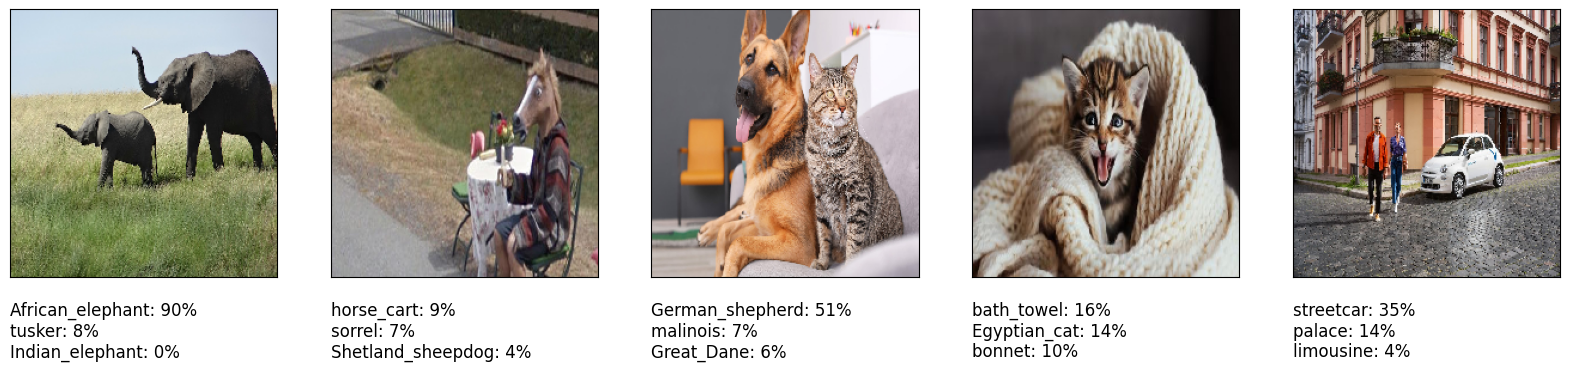

In [5]:
urls = ['https://hdvirtual.us.es/discovirt/index.php/s/NWboNQ94dmFJcxn/download', 
        'https://hdvirtual.us.es/discovirt/index.php/s/y53yDBZTBDcRSfH/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/nDfkmx2xs7zGCBM/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/jjJrdA2cS7xT3yQ/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/YwWT4E9kDHf25RH/download']

def descargar_imagenes(urls, size=224):
    batch = []
    raw_images = []
    for i, url in enumerate(urls):
        file_name = f'img{i}.jpg'
        # Descargamos la imagen
        urllib.request.urlretrieve(url, file_name)

        # La leemos con un tamaño 224 x 224 (según la entrada de la red)
        img = tf.keras.preprocessing.image.load_img(file_name, target_size=(size, size))

        # Convertimos en un array de numpy
        x = tf.keras.preprocessing.image.img_to_array(img)

        raw_images.append(np.copy(x)/255)

        # y finalmente preprocesamos
        x = tf.keras.applications.vgg16.preprocess_input(x)

        # la agregamos a nuestro batch
        batch.append(x)

    batch = np.array(batch)
    return batch, raw_images

batch, raw_images = descargar_imagenes(urls)

preds = model.predict(batch)
texts = ['\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])
                    for dpred in tf.keras.applications.vgg16.decode_predictions(preds, top=3)]

images = [{'image': im, 'tag': tag} for im, tag in zip(raw_images, texts)]
show_images(images)    

En el caso de los elfantes, las tres clases principales son:

* Elefante Africano (con un 90.9% de probabilidad)
* Tusker (elefante) (con un 8.6% de probabilidad)
* Elefante Indio (con un 0.4% de probabilidad)

La red reconoce a elefante africano como la clase más probable.

Vamos a necesitar acceder a las entradas de la `softmax`. Para ello debemos hacer un pepueña modificación en la red: anular dicha función de activación. La siguiente función es una función de utilidad, tomada de *keras-vis* que nos permite hacer dicha alteración:

In [6]:
import os 
import tempfile
def apply_modifications(model, custom_objects=None):
    """
    Aplicamos las modificaciones realizadas en el modelo creando un nuevo grafo de
    computación. Para poder modificar el grafo tenemos que grabar y leer el modelo.
    """
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)


Desactivamos la activación asignadole una activación lineal y aplicamos el cambio:

In [7]:
model.layers[-1].activation = tf.keras.activations.linear
model = apply_modifications(model)

Como función de *loss* usaremos la entrada a la softmax, las envidencias que ahora son la salida de la capa de predicciones:

In [8]:
layer_name = 'predictions'

layer_output = model.get_layer(layer_name).output

Obtenemos los gradientes respecto a la entrada:

In [9]:
def get_saliency(model_loss, im):
    im = tf.convert_to_tensor(im)
    with tf.GradientTape() as tape:
        tape.watch(im)
        loss = model_loss(tf.expand_dims(im, axis=0))
        
    grads = tape.gradient(loss, im)
    
    return grads

def get_heatmaps(base_model, layer_output, klasses, images):
    
    heatmaps = []
    for klass, im in zip(klasses, images):
        model_loss = tf.keras.models.Model(base_model.input, layer_output[:, int(klass)])
        
        heatmaps.append(get_saliency(model_loss, im).numpy())
        
    return heatmaps
        

klasses = np.argmax(preds, axis=-1)
heatmaps = get_heatmaps(model, layer_output, klasses, batch)

Por último, para obtener una mejor visualización, escalamos y obtenemos el máximo de cada canal (R,G,B):

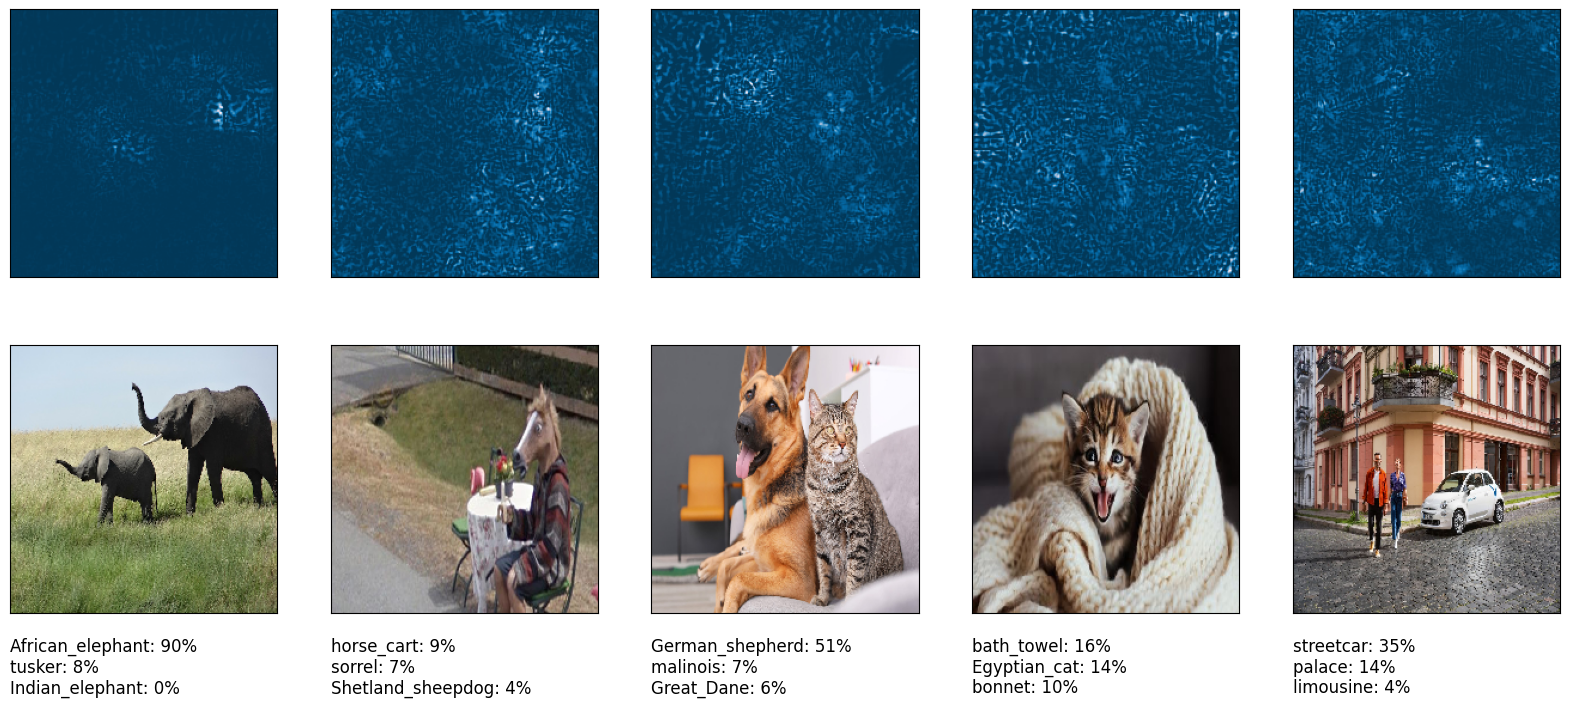

In [10]:
import numpy as np
grads = []
for gv in heatmaps:
    g = np.clip(gv, 0, gv.max()) / gv.max()
    g = g.max(axis=2) 
    
    grads.append(g)

grads = [{'image': g, 'cmap': 'PuBu_r'} for g in grads]
show_images(*[grads, images])


Como vemos, los píxeles más importantes, según el saliency map, son los correspondientes a la localización de los objetos pero sin embargo hay mucho ruido.



### Grad-CAM

En ["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization." Ramprasaath R. Selvaraju et al., Cornell University Library, March 21, 2017](https://arxiv.org/abs/1610.02391) desarrollaron una generalización el método que vimos usando las capas GAP en la que no era necesario re-entrenar en el caso de la red no hubiera sido entrenada originalmente con una GAP.

La idea es muy simple, consiste en tomar el mapa de cartacerísticas de una capa convolucional que produce una imagen de entrada y ponderar cada mapa con los gradientes de la clase con respecto a ese canal. Lo único que vamos a cambiar es esa ponderación, que antes eran los pesos aprendidos por la última capa densa, por los gradientes.

De nuevo, vamos a probar esta técnica usando una red preentrenada, pero esta vez vamos a usar la VGG16 que no tiene la AGP:

Como en el caso anterior leemos la imagen y la preprocesamos usando la función correspondiente de la vgg16:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


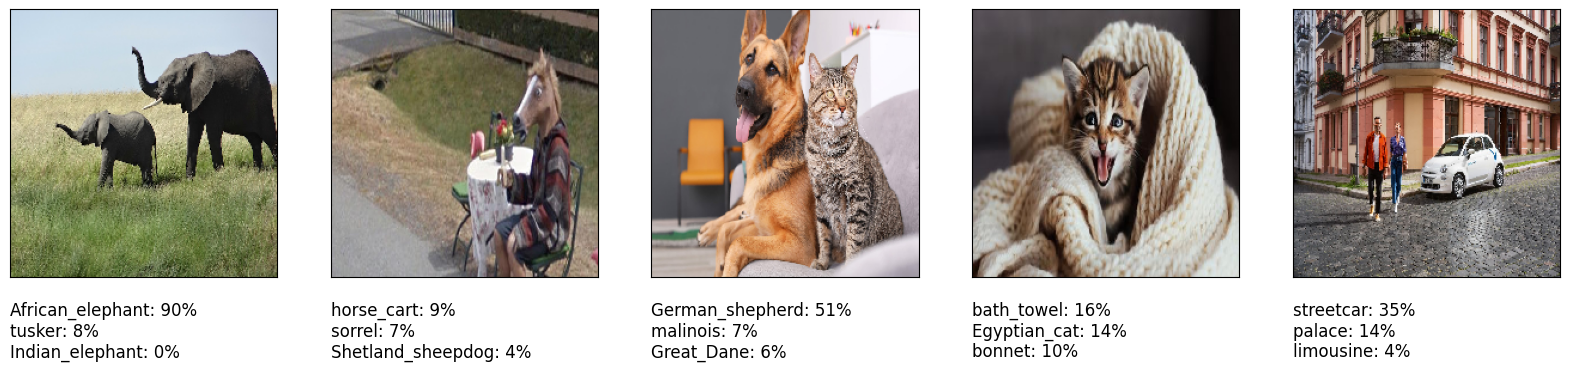

In [11]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet')

batch = []
for x in raw_images:

    # preprocesamos
    x = tf.keras.applications.vgg16.preprocess_input(np.copy(x) * 255)
    
    # la agregamos a nuestro batch
    batch.append(x)

batch = np.array(batch)
preds = model.predict(batch)
texts = ['\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])
                    for dpred in tf.keras.applications.vgg16.decode_predictions(preds, top=3)]

images = [{'image': im, 'tag': tag} for im, tag in zip(raw_images, texts)]
show_images(images)    

En siguiente código lleva a cabo el método Grad-CAM:


/Users/sergiosantiago/developments/master/AP/S8/venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_72']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


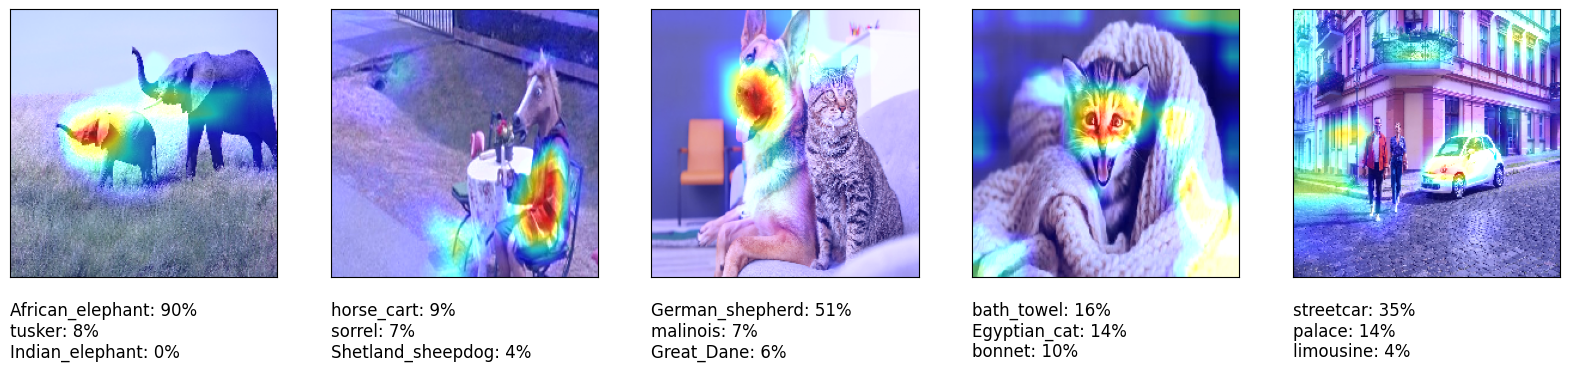

In [12]:
def crear_gram_heatmap(im, model, last_conv_layer_name, pred_index=None):
    # Creamos un modelo con dos salidas: las predicciones y la capa convolucional a usar
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Calculamos el gradiente de la clase que tenga mayor probabilidad respecto 
    # a las activaciones de la capa
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.array([im]))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculamos un vector para ponderar los mapas de características en 
    # función de como han influido en la prediccíon. 
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicamos los mapas por los pesos.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ weights[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizamos entre 0 y 1 para una mejor visualización
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


superpuestas = []
heatmaps = []
for raw_im, im, pred in zip(raw_images, batch, preds):
    heatmap = crear_gram_heatmap(im, model, 'block5_conv3', np.argmax(pred))
    
    # redimencionamos para que se ajuste al tamaño de la original
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    
    # aplicamos el método anterior para superponer el heatmap
    heatmap = 255 - np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + (raw_im * 255) 

        
    dpred = tf.keras.applications.vgg16.decode_predictions(np.array([pred]), top=3)[0]
    text = '\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])


    superpuestas.append({'image': superimposed_img/255, 'tag': text})

show_images(superpuestas)  

### T1

De los dos modelos entrenados para reconocer expresiones faciales, al segundo se le ha introducido un sesgo en las imágenes de entrenamiento.


Revisa las dos técnicas de explicabilidad para redes neuronales explicadas en el notebook adjunto y aplícalas para investigar el sesgo presente en el segundo modelo. Analiza y describe una posible causa del sesgo detectado, y añade imágenes generadas por los métodos de explicabilidad que respalden tu hipótesis.

In [13]:
model_url = 'https://hdvirtual.us.es/discovirt/index.php/s/56Go2HStYwmrLmZ/download'
urllib.request.urlretrieve(model_url, 'face_expressions.keras')

face_model1 = tf.keras.models.load_model('./face_expressions.keras')

model_url = 'https://hdvirtual.us.es/discovirt/index.php/s/dXt7niSkSXanPDS/download'
urllib.request.urlretrieve(model_url, 'face_expressions2.keras')

face_model2 = tf.keras.models.load_model('./face_expressions2.keras')

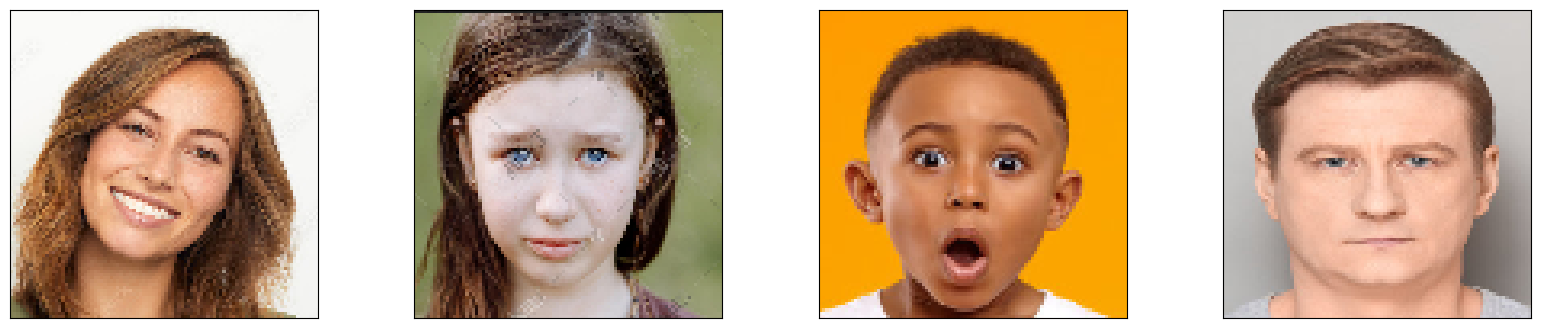

In [14]:
facial_images = [
    "https://hdvirtual.us.es/discovirt/index.php/s/oyABoqf3K5spYm3/download",
    "https://hdvirtual.us.es/discovirt/index.php/s/TfFmKeZnzjnPoRX/download",
    "https://hdvirtual.us.es/discovirt/index.php/s/poCPKZjJ8qbr3bf/download",
    "https://hdvirtual.us.es/discovirt/index.php/s/GzorxJxzHLqti8W/download"
    
]

batch, raw_images = descargar_imagenes(facial_images, size=96)

show_images([{'image': im} for im in raw_images])

In [15]:
preds_model1 = face_model1.predict(batch)

I0000 00:00:1745259791.419935 16794742 service.cc:152] XLA service 0x3260e1f60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745259791.419950 16794742 service.cc:160]   StreamExecutor device (0): Host, Default Version


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


I0000 00:00:1745259791.776236 16794742 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
preds_model2 = face_model2.predict(batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


In [17]:
face_model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,468,494 (162.00 MB)

 Trainable params: 13,577,668 (51.79 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 27,155,338 (103.59 MB)

In [22]:
superpuestas = []
heatmaps = []
for raw_im, im, pred in zip(raw_images, batch, preds_model1):
    heatmap = crear_gram_heatmap(im, face_model1, 'block5_conv3', np.argmax(pred))
    
    # redimencionamos para que se ajuste al tamaño de la original
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    
    # aplicamos el método anterior para superponer el heatmap
    heatmap = 255 - np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + (raw_im * 255) 

        
    #dpred = face_model1.decode_predictions(np.array([pred]), top=3)[0]
    #text = '\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])


    superpuestas.append({'image': superimposed_img/255, 'tag': "text"})

show_images(superpuestas) 

/Users/sergiosantiago/developments/master/AP/S8/venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 96, 96, 3))
  warnings.warn(msg)


AttributeError: 'Functional' object has no attribute 'decode_predictions'